# Importing Dependencies

### the notebook in a nutshell 
- importing 
software dependencies we need
- load_data (please read its description it supposed to be very easy to deal with it)

###  preprocesssing 
- I stored some important variables, then I used log transformation for long tailed distributions

- iterative imputer just like what `MAAB` Advised

- transormed the categorical features to be from the string type just to avoid some fitting isssues cause by the 
OneHotEncoder.

- droped the `participant_ID` after storing it for stratification

- I scaled quantative data and also FMRI data 

### modeling
- base model is logisitc regression with l2 regulization (fancy name for punishing the model to stop overfitting to noise) 
- wrapped inside a multioutput classifier that just gives it the ability to predict 2 targets simultaneously
### validation 
- 5 splits stratifiedKFold works fine no need for grouping as participants are unique 
- regular stratified  = 0.5901173137436236
- RepeatedStratifiedKFold =0.5865925294336686 with 7 minutese delay

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from scipy.stats import hmean
from sklearn.multioutput import MultiOutputClassifier
import scipy
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer #it might not work directly if not try the following code line

from sklearn.model_selection import StratifiedGroupKFold,StratifiedKFold,RepeatedStratifiedKFold
from pathlib import Path
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

# Reading Data

In [60]:
"""
just drop the path of your new data directory nothing more than that. 

"""
path = r"C:\Users\Maab\Desktop\ADHD_Kaggle_Competition\Repo\WiDS-Datathon-2025\Data\raw"

def read_data(base_path:str) -> pd.DataFrame :
    path = Path(base_path)
    trc=pd.read_excel(path /'TRAIN_NEW'  / 'TRAIN_CATEGORICAL_METADATA_new.xlsx')
    trq=pd.read_excel(path /'TRAIN_NEW'  / 'TRAIN_QUANTITATIVE_METADATA_new.xlsx')
    trf=pd.read_csv(path   /'TRAIN_NEW'  / 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
    trs=pd.read_excel(path /'TRAIN_NEW'  / 'TRAINING_SOLUTIONS.xlsx')  
    tsc=pd.read_excel(path /'TEST'      / 'TEST_CATEGORICAL.xlsx')
    tsq=pd.read_excel(path /'TEST'       / 'TEST_QUANTITATIVE_METADATA.xlsx')    
    tsf=pd.read_csv(path   /'TEST'       / 'TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')    
    sub=pd.read_excel(path / 'SAMPLE_SUBMISSION.xlsx')
    dic=pd.read_excel(path /'Data Dictionary.xlsx')
    return trc, trq, trf, trs, tsc, tsq, tsf, sub, dic

trc, trq, trf, trs, tsc, tsq, tsf, sub, dic = read_data(base_path=path)

# Data Merging 
cq = pd.merge(trc, trq, on='participant_id', how='left')
feat = pd.merge(cq, trf, on='participant_id', how='left')  
qc = pd.merge(tsc, tsq, on='participant_id', how='left')
train = pd.merge(feat, trs, on='participant_id', how='left') 
test = pd.merge(qc, tsf, on='participant_id', how='left')

# Preprocessing

### Setup

In [33]:
# Highlighting important variables. 
# note that I did't deal with the quantative data trq as categorical
# I will use the OneHotEncoder for the categorical data as we have some data trap that I don't think we can use the label encoder for. 

for feature in trc.columns:
    train[feature] = train[feature].astype(object)
train_ids = train['participant_id']
test_ids = test['participant_id'] # I will store them for later usage in grouping in validation why?  I don't want the same user to appear in both train and test. 
num_feats = [feature for feature in train.columns if train[feature].dtype == 'float64']
cat_feats = [feature for feature in train.columns if train[feature].dtype == 'object'] # seperate categorical and numerical features help me reteriving them later easily for preprocessing.
target_cols = ['ADHD_Outcome', 'Sex_F']
groups = train_ids

### Log Transformation

In [34]:
# Features with positive skewness and non-negative values: apply log transformation
# num_feats[:18] Don't transform fMRI data because it has negative values
log_features = [f for f in num_feats[:18] if (train[f] >= 0).all() and scipy.stats.skew(train[f]) > 0.5]  # Only apply to features with significant positive skew

# Apply log transformation for the selected features
for feature in log_features:
    train[feature] = np.log1p(train[feature])  # Apply log(x+1) to handle skewed features
    test[feature] = np.log1p(test[feature])    # Apply log(x+1) to test data as well


### Missing Values

In [35]:
# Checking if target columns in train set (adhd and sex) have missing values
train_missing_features_to_impute = train[target_cols].columns[train[target_cols].isnull().any()].tolist()
print(train_missing_features_to_impute) # print column name that has missing values if any.

[]


In [36]:
'''
Train has 25 features/columns with missing values: ['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan']
Test  has 23 features/columns with missing values: ['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']
fMRI has no missing values
Extra columns in train: ['MRI_Track_Age_at_Scan', 'MRI_Track_Scan_Location']
'''

# Find columns with missing values only
train_missing_features_to_impute = train.columns[train.isnull().any()].tolist() # List of features with missing values in train, only 25 and no missing data in fMRI data
test_missing_features_to_impute = test.columns[test.isnull().any()].tolist() # List of features with missing values in test, only 23 and no missing data in fMRI data

# Initialize the imputer
imputer = IterativeImputer(estimator=LassoCV(random_state=42), max_iter=5, random_state=42)

# Impute in-place
train[train_missing_features_to_impute] = imputer.fit_transform(train[train_missing_features_to_impute])
test[test_missing_features_to_impute] = imputer.fit_transform(test[test_missing_features_to_impute])

### Encode Categorical Features

In [37]:
# Convert all categorical features to strings (to avoid mixed types)
for feature in cat_feats:
    train[feature] = train[feature].astype(str)
    test[feature] = test[feature].astype(str)

# One-Hot Encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

for feature in cat_feats:
    if feature == 'participant_id':  # Skip participant_id since it's not a feature
        continue

    # Apply OneHotEncoder
    train_encoded = encoder.fit_transform(train[[feature]])
    test_encoded = encoder.transform(test[[feature]])

    # Convert encoded features to DataFrame and append them to the original data
    train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out([feature]))
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out([feature]))

    # Drop the original feature and concatenate the new encoded columns
    train = pd.concat([train.drop(columns=[feature]), train_encoded_df], axis=1)
    test = pd.concat([test.drop(columns=[feature]), test_encoded_df], axis=1)

### Drop Irrelevant Columns

In [38]:
for df in (train,test):
    df.drop(columns=['participant_id'], inplace=True) 

### Scale Numerical Features

In [39]:

scaler = StandardScaler()

# Only apply scaling to numerical columns that are not part of the target or categorical features
numerical_features = [col for col in train.columns if col not in target_cols and col not in cat_feats]

# Fit scaler on the numerical features of the train set and transform train and test sets
train[numerical_features] = scaler.fit_transform(train[numerical_features])  # Fit and transform for train set
test[numerical_features] = scaler.transform(test[numerical_features])        # Only transform for test set (avoid data leakage)


# Training and Validation

In [ ]:
features = test.columns 
n_splits = 5 
cv = StratifiedKFold(n_splits=n_splits)
base_model = LogisticRegression(random_state=7,penalty='l2', C=0.02,class_weight="balanced")

model = MultiOutputClassifier(base_model)

# This function will be used to validate the model on one fold at a time, it will called 5 times (5 folds)
def validate(trainset, testset, target_cols):
    """This function takes in:
    trainset: your training data (features + targets)
    testset: your test data (same structure)
    target_cols: list of target column names (because it's a multi-output model)
    """
    weights = ((trainset['Sex_F'] == 1) & (trainset['ADHD_Outcome'] == 1)).astype(int) + 1
    model.fit(trainset.drop(columns=target_cols), trainset[target_cols],sample_weight=weights)
    pred = model.predict(testset.drop(columns=target_cols))
    valid_idx = testset[target_cols].notna().all(axis=1)
    
    valid_testset = testset.loc[valid_idx, target_cols]
    valid_pred = pred[valid_idx]
    f1_scores = [f1_score(valid_testset[col], valid_pred[:, i]) for i, col in enumerate(target_cols)]
    
    # print(f"F1-scores per target: {dict(zip(target_cols, f1_scores))}")
    
    return f1_scores


stds = [] # List to store the standard deviation of each target column in every test split
F1s = [] # List to store the F1 scores returned by your validate() function for each fold

# Cross-validation loop: Stratified K-Fold

for fold_number, (train_index, test_index) in enumerate(cv.split(train.drop(columns=target_cols), train[target_cols[0]]), 1):
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    
    # Get the F1 scores for ADHD and Sex_F
    f1_scores = validate(train_v, test_v, target_cols)
    
    # Print fold number and F1 scores
    print(f"\n==== Fold {fold_number} ===")
    for i, col in enumerate(target_cols):
        print(f"{col} -> F1: {f1_scores[i]:.4f}")
    
    # Append standard deviations of the test set to the stds list
    stds.append(test_v[target_cols].std())
    
    # Append F1 scores to the F1s list
    F1s.append(f1_scores)

F1s = np.array(F1s)

mean_f1_scores = F1s.mean(axis=0)
print("\n==== Overall Results ===")
print("Mean F1-scores:")
for i, target in enumerate(target_cols):
    print(f"    {target} -> F1: {mean_f1_scores[i]:.4f}")
    
    
f1_stds = F1s.std(axis=0)

print("\nF1-score stds:")
for i, target in enumerate(target_cols):
    print(f"    {target} -> Std: {f1_stds[i]:.4f}")
    
print("\nStandard deviations of test sets:")
for std in stds:
    print(f"    {std.to_dict()}")

print("\nscore mean (ADHD Sex): ", np.mean(F1s, axis=0))
score = hmean(F1s, axis=0)
score = hmean(score, axis=0)
print("\nFinal Overall Harmonic Mean (Mimic Leaderboard): ", score)



### Trying my own code on Ahmed's validation to see if results are similar. Using LogisticRegressionCV Stratify on ADHD

In [ ]:
"""
ayo so there is this modeling thing, the parts are:
- now we train two separate models instead of using MultiOutputClassifier
- each model is a LogisticRegressionCV that tunes regularization using cross-validation
- preprocessing still applies before this (pipeline, imputation, scaling, PCA, etc.)
"""

# Constants
target_cols = ['ADHD_Outcome', 'Sex_F']
n_splits = 5
SEED = 42  # set your seed if not defined elsewhere
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Validation function for two independent models
def validate(trainset, testset, target_cols):
    f1_scores = []

    for target in target_cols:
        # LogisticRegressionCV for this target
        model = LogisticRegressionCV(
            penalty="l2",
            Cs=10,
            cv=5,
            fit_intercept=True,
            scoring="f1",
            solver="saga",
            random_state=SEED,
            class_weight="balanced",
            max_iter=1000
        )

        # Define weights if needed (only for ADHD, in this case)
        if target == 'ADHD_Outcome':
            weights = ((trainset['Sex_F'] == 1) & (trainset['ADHD_Outcome'] == 1)).astype(int) + 1
            model.fit(trainset.drop(columns=target_cols), trainset[target], sample_weight=weights)
        else:
            model.fit(trainset.drop(columns=target_cols), trainset[target])

        # Predict
        preds = model.predict(testset.drop(columns=target_cols))

        # Mask valid rows (non-NaN)
        valid_idx = testset[target].notna()
        true_vals = testset.loc[valid_idx, target]
        valid_preds = preds[valid_idx]

        # Compute F1
        score = f1_score(true_vals, valid_preds)
        f1_scores.append(score)

    return f1_scores


stds = []
F1s = []

for fold_number, (train_index, test_index) in enumerate(cv.split(train.drop(columns=target_cols), train[target_cols[0]]), 1):
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]

    f1_scores = validate(train_v, test_v, target_cols)

    print(f"\n==== Fold {fold_number} ===")
    for i, col in enumerate(target_cols):
        print(f"{col} -> F1: {f1_scores[i]:.4f}")

    stds.append(test_v[target_cols].std())
    F1s.append(f1_scores)

F1s = np.array(F1s)

mean_f1_scores = F1s.mean(axis=0)
print("\n==== Overall Results ===")
print("Mean F1-scores:")
for i, target in enumerate(target_cols):
    print(f"    {target} -> F1: {mean_f1_scores[i]:.4f}")

f1_stds = F1s.std(axis=0)
print("\nF1-score stds:")
for i, target in enumerate(target_cols):
    print(f"    {target} -> Std: {f1_stds[i]:.4f}")

print("\nStandard deviations of test sets:")
for std in stds:
    print(f"    {std.to_dict()}")

print("\nscore mean (ADHD, Sex):", np.mean(F1s, axis=0))
score = hmean(F1s, axis=0)
score = hmean(score, axis=0)
print("\nFinal Overall Harmonic Mean (Mimic Leaderboard):", score)


In [ ]:

mean_f1_scores = F1s.mean(axis=0)
print("\n==== Overall Results ===")
print("Mean F1-scores:")
for i, target in enumerate(target_cols):
    print(f"    {target} -> F1: {mean_f1_scores[i]:.4f}")

f1_stds = F1s.std(axis=0)
print("\nF1-score stds:")
for i, target in enumerate(target_cols):
    print(f"    {target} -> Std: {f1_stds[i]:.4f}")

print("\nStandard deviations of test sets:")
for std in stds:
    print(f"    {std.to_dict()}")

print("\nscore mean (ADHD, Sex):", np.mean(F1s, axis=0))
score = hmean(F1s, axis=0)
score = hmean(score, axis=0)
print("\nFinal Overall Harmonic Mean (Mimic Leaderboard):", score)

"""
Stratify/Balance on ADHD
    model = LogisticRegressionCV(
        penalty="l2",
        Cs=10,
        cv=5,
        fit_intercept=True,
        scoring="f1",
        solver="saga",
        random_state=SEED,
        class_weight="balanced",
        max_iter=1000
    )
"""



==== Overall Results ===
Mean F1-scores:
    ADHD_Outcome -> F1: 0.6584
    Sex_F -> F1: 0.6080

F1-score stds:
    ADHD_Outcome -> Std: 0.0160
    Sex_F -> Std: 0.0285

Standard deviations of test sets:
    {'ADHD_Outcome': 0.46457326315492786, 'Sex_F': 0.4708992252403255}
    {'ADHD_Outcome': 0.46621751673905226, 'Sex_F': 0.47381526069616847}
    {'ADHD_Outcome': 0.46621751673905215, 'Sex_F': 0.4752128960101643}
    {'ADHD_Outcome': 0.46509817553248467, 'Sex_F': 0.48319731732943894}
    {'ADHD_Outcome': 0.46509817553248467, 'Sex_F': 0.4742973664679305}

score mean (ADHD, Sex): [0.65842984 0.60804232]

Final Overall Harmonic Mean (Mimic Leaderboard): 0.6313531527170896


In [20]:
train.columns[:25]

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       '0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn',
       '0throw_4thcolumn', '0throw_5thcolumn', '0throw_6thcolumn',
       '0throw_7thcolumn'],
      dtype='object')

In [21]:
# Group feature names based on your analysis
female_features = [
    'ColorVision_CV_Score',
    'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Prosocial',
    'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Generating_Impact',
    'APQ_P_APQ_P_PM'
]

male_features = [
    'SDQ_SDQ_Hyperactivity',
    'APQ_P_APQ_P_PP',
    'SDQ_SDQ_Externalizing',
    'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_INV',
    'APQ_P_APQ_P_OPD',
    'SDQ_SDQ_Peer_Problems'
]

# Create new summed features
train['female_symptom_score'] = train[female_features].sum(axis=1)
train['male_symptom_score'] = train[male_features].sum(axis=1)

test['female_symptom_score'] = test[female_features].sum(axis=1)
test['male_symptom_score'] = test[male_features].sum(axis=1)


In [24]:
print(train["male_symptom_score"])

0       1.119183
1       4.531588
2       3.012349
3      -2.396386
4       5.312615
          ...   
1208   -0.484896
1209   -2.051023
1210   -0.637597
1211    3.937462
1212   -0.864600
Name: male_symptom_score, Length: 1213, dtype: float64


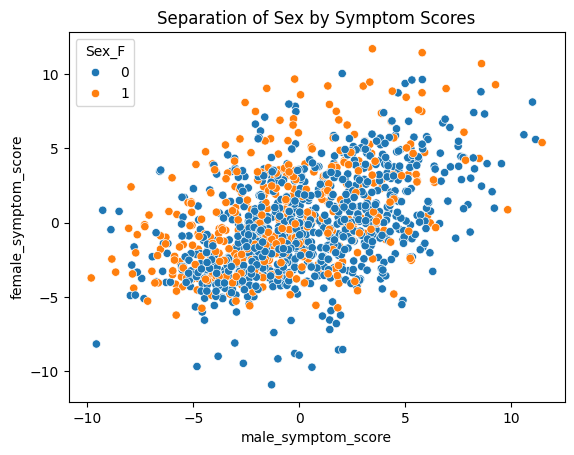

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume you have train['Sex_F'] (0=male, 1=female)
sns.scatterplot(
    x='male_symptom_score',
    y='female_symptom_score',
    hue='Sex_F',
    data=train
)
plt.title('Separation of Sex by Symptom Scores')
plt.show()


In [57]:
# Your coefficients (estimated from your description)
# female_coefs = {
#     'ColorVision_CV_Score': 2.900,
#     'SDQ_SDQ_Emotional_Problems': 2.814,
#     'SDQ_SDQ_Prosocial': 2.661,
#     'SDQ_SDQ_Internalizing': 1.382,
#     'SDQ_SDQ_Conduct_Problems': 1.329,
#     'SDQ_SDQ_Generating_Impact': 1.109,
#     'APQ_P_APQ_P_PM': 0.642
# }


female_coefs = {
    'ColorVision_CV_Score': 29.00,
    'SDQ_SDQ_Emotional_Problems': 28.14,
    'SDQ_SDQ_Prosocial': 26.61,
    'SDQ_SDQ_Internalizing': 13.82,
    'SDQ_SDQ_Conduct_Problems': 13.29,
    'SDQ_SDQ_Generating_Impact': 11.09,
    'APQ_P_APQ_P_PM': 6.42
}

male_coefs = {
    'SDQ_SDQ_Hyperactivity': -3.088,
    'MRI_Track_Age_at_Scan': -2.147,
    'APQ_P_APQ_P_PP': -1.903,
    'SDQ_SDQ_Externalizing': -1.447,
    'APQ_P_APQ_P_CP': -1.380,
    'APQ_P_APQ_P_INV': -0.437,
    'APQ_P_APQ_P_OPD': -0.676,
    'SDQ_SDQ_Peer_Problems': -0.596
}

# Compute weighted sums
train['female_symptom_score'] = sum(train[feat] * coef for feat, coef in female_coefs.items())
train['male_symptom_score'] = sum(train[feat] * coef for feat, coef in male_coefs.items())

# (repeat for test if needed)


In [51]:
train['ADHD_Outcome'] 

0       1
1       1
2       0
3       0
4       1
       ..
1208    0
1209    1
1210    1
1211    1
1212    0
Name: ADHD_Outcome, Length: 1213, dtype: int64

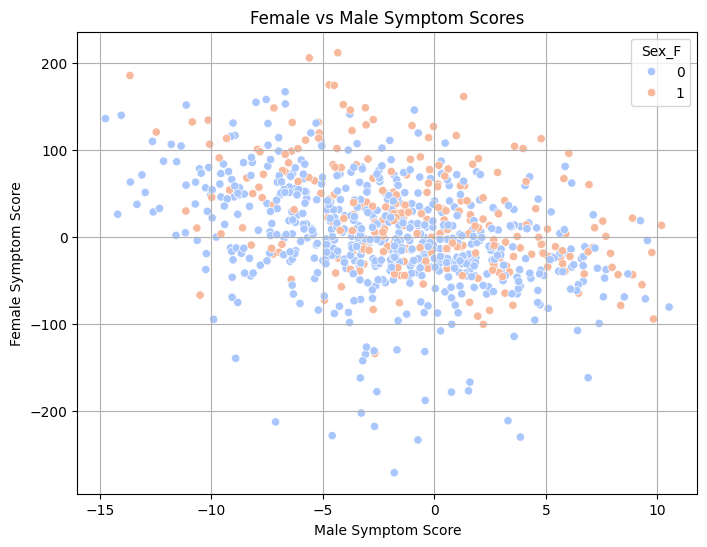

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns


# adhd_positive = train[y_ADHD == 1]


plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train[train['ADHD_Outcome'] == 1], 
    x='male_symptom_score', 
    y='female_symptom_score', 
    hue='Sex_F',  # assuming you have a 'Sex' column (0 = male, 1 = female or similar)
    palette='coolwarm'
)

plt.title('Female vs Male Symptom Scores')
plt.xlabel('Male Symptom Score')
plt.ylabel('Female Symptom Score')
plt.grid(True)
plt.show()


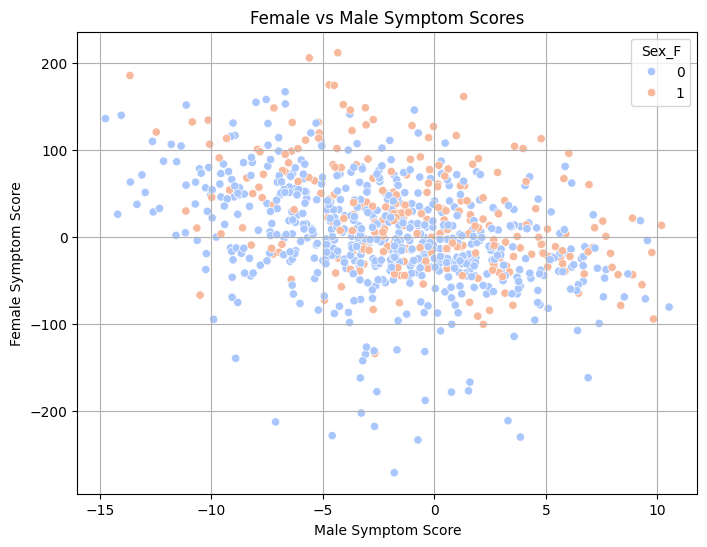

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns


female_coefs = {
    'ColorVision_CV_Score': 29.00,
    'SDQ_SDQ_Emotional_Problems': 28.14,
    'SDQ_SDQ_Prosocial': 26.61,
    'SDQ_SDQ_Internalizing': 13.82,
    'SDQ_SDQ_Conduct_Problems': 13.29,
    'SDQ_SDQ_Generating_Impact': 11.09,
    'APQ_P_APQ_P_PM': 6.42
}

male_coefs = {
    'SDQ_SDQ_Hyperactivity': -3.088,
    'MRI_Track_Age_at_Scan': -2.147,
    'APQ_P_APQ_P_PP': -1.903,
    'SDQ_SDQ_Externalizing': -1.447,
    'APQ_P_APQ_P_CP': -1.380,
    'APQ_P_APQ_P_INV': -0.437,
    'APQ_P_APQ_P_OPD': -0.676,
    'SDQ_SDQ_Peer_Problems': -0.596
}

# Compute weighted sums
train['female_symptom_score'] = sum(train[feat] * coef for feat, coef in female_coefs.items())
train['male_symptom_score'] = sum(train[feat] * coef for feat, coef in male_coefs.items())




plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train[train['ADHD_Outcome'] == 1], 
    x='male_symptom_score', 
    y='female_symptom_score', 
    hue='Sex_F',  # assuming you have a 'Sex' column (0 = male, 1 = female or similar)
    palette='coolwarm'
)

plt.title('Female vs Male Symptom Scores')
plt.xlabel('Male Symptom Score')
plt.ylabel('Female Symptom Score')
plt.grid(True)
plt.show()


In [43]:
train['Sex_F']
# train.shape

0       0
1       0
2       1
3       1
4       0
       ..
1208    1
1209    0
1210    1
1211    0
1212    1
Name: Sex_F, Length: 1213, dtype: int64

# Inference and Submission

In [ ]:
def inference(testdata, model_adhd, model_sex):
    # Fit ADHD model
    model_adhd.fit(train.drop(columns=["ADHD_Outcome", "Sex_F"]), train["ADHD_Outcome"])
    
    # Fit Sex model
    model_sex.fit(train.drop(columns=["ADHD_Outcome", "Sex_F"]), train["Sex_F"])
    
    # Predict
    adhd_pred = model_adhd.predict(test)
    sex_pred = model_sex.predict(test)

    # Prepare submission
    sub['ADHD_Outcome'] = adhd_pred
    sub['Sex_F'] = sex_pred
    sub.to_csv(f'../submission{score}.csv', index=False)



model_adhd = LogisticRegressionCV(
    penalty="l2",
    Cs=10,
    cv=5,
    fit_intercept=True,
    scoring="f1",
    solver="saga",
    random_state=SEED,
    class_weight="balanced",
    max_iter=1000
)

model_sex = LogisticRegressionCV(
    penalty="l2",
    Cs=10,
    cv=5,
    fit_intercept=True,
    scoring="f1",
    solver="saga",
    random_state=SEED,
    class_weight="balanced",
    max_iter=1000
)

inference(test, model_adhd, model_sex)

'''
Code ran in 138m 58.8s
'''

In [ ]:
def inference(testdata, model):

    model.fit(train.drop(columns=["ADHD_Outcome", "Sex_F"], axis=1), train[["ADHD_Outcome", "Sex_F"]])
    y_pred = model.predict(test)
    sub['ADHD_Outcome'] = y_pred[:, 0] 
    sub['Sex_F'] = y_pred[:, 1]        
    sub.to_csv(f'../submission{score}.csv', index=False)
    
inference(test, model)
